![download.png](download.png)


## Import Packages

In [1]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder

from xgboost import XGBRegressor

# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "tasty_data_scientist",
    "warehouse": "tasty_ds_wh",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [3]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Preview The Data

In [4]:
tasty_bytes_orders_v.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"           |"COUNTRY"  |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"PLACEKEY"           |"LOCATION_NAME"  |"TOP_CAT

In [5]:
tasty_bytes_customer_loyalty.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

## Data Exploration

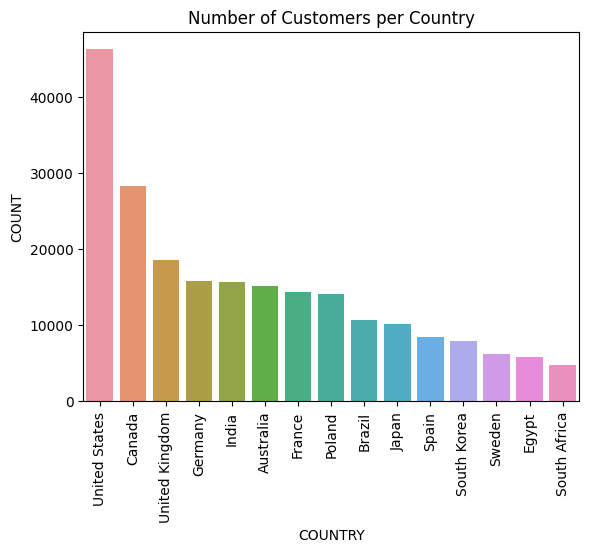

In [6]:
#Unique Customers
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Customers per Country')
plt.show()

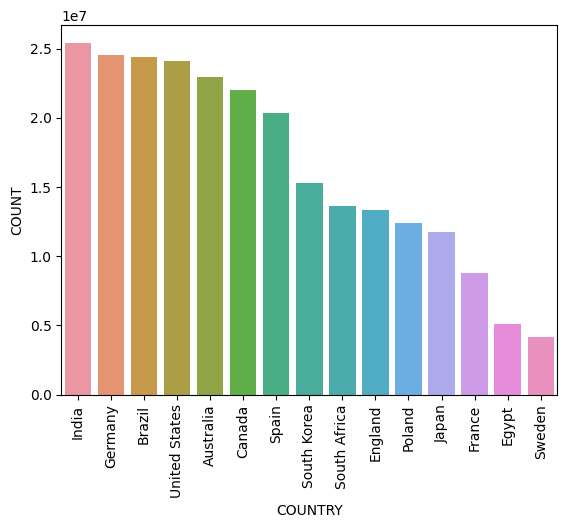

In [7]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [8]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

In [9]:
#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

In [10]:
#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)
last_tran_country_sdf.show()

---------------------------------------------------------------------------------
|"COUNTRY"    |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |
---------------------------------------------------------------------------------
|Canada       |2022-11-01                |2022-10-18    |2022-09-18             |
|Brazil       |2022-11-01                |2022-10-18    |2022-09-18             |
|Germany      |2022-11-01                |2022-10-18    |2022-09-18             |
|Australia    |2022-11-01                |2022-10-18    |2022-09-18             |
|Japan        |2022-11-01                |2022-10-18    |2022-09-18             |
|Poland       |2022-11-01                |2022-10-18    |2022-09-18             |
|South Korea  |2022-11-01                |2022-10-18    |2022-09-18             |
|Spain        |2022-11-01                |2022-10-18    |2022-09-18             |
|Sweden       |2022-11-01                |2022-10-18    |2022-09-18             |
|England      |2

In [11]:
#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

last_tran_country_sdf_join.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK

In [12]:
#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

In [13]:
#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

In [14]:
#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

In [15]:
#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

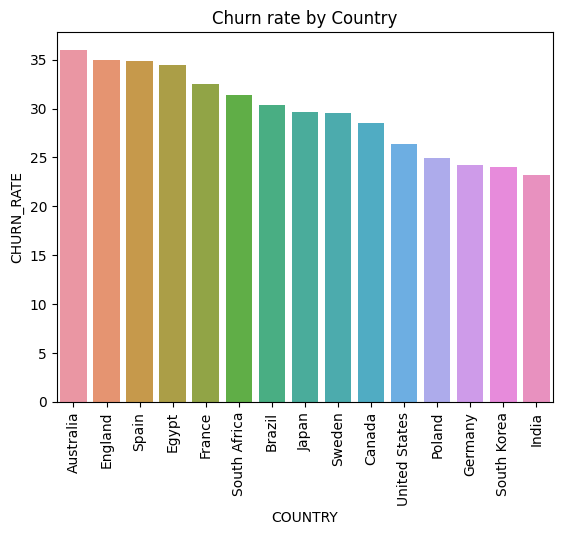

In [16]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

Since Australia has quite a number of customers, a huge number of transactions and the highest churn rate. Therefore, we have decided to focus on Australia.

In [17]:
#Filter to only Australia
filtered_df=tasty_bytes_orders_v.filter(F.col('COUNTRY')=='Australia')

#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_customer_loyalty.join(
    right=filtered_df,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [19]:
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CITY"  |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"FAVOURITE_BRAND"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           

In [20]:
loyal_customer_orders.agg(F.max('ORDER_TS')).show()

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:42:53  |
-----------------------



In [21]:
#Recency
recency=loyal_customer_orders.group_by('CUSTOMER_ID').max('ORDER_TS').to_pandas()
recency['RECENCY']=(dt.datetime(2022,11,1,22,42,53)-pd.to_datetime(recency['MAX(ORDER_TS)'])).dt.days

#Frequency
frequency=loyal_customer_orders.group_by('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency')).to_pandas()

#Monetary
monetary=loyal_customer_orders.group_by('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary')).to_pandas()

RFM_table=recency.merge(right=frequency, how="inner",on='CUSTOMER_ID')
RFM_table=RFM_table.merge(right=monetary,how='inner',on='CUSTOMER_ID')
RFM_table.drop(labels='MAX(ORDER_TS)',inplace=True,errors='ignore')

# quantiles_1 = RFM_table[['RECENCY','FREQUENCY','MONETARY']].quantile(q=[0.2,0.4,0.6,0.8])

# # Converting quantiles to a dictionary, easier to use.
# quantiles = quantiles_1.to_dict()
# ##  RFM Segmentation ----
# RFM_Segment = RFM_table.copy()
# # Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
# def R_Class(x,p,d):
#     if x <= d[p][0.2]:
#         return 5
#     elif x <= d[p][0.4]:
#         return 4
#     elif x <= d[p][0.6]: 
#         return 3
#     elif x<=d[p][0.8]:
#         return 2 
#     else:
#         return 1
    
# # Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
# def FM_Class(x,p,d):
#     if x <= d[p][0.2]:
#         return 1
#     elif x <= d[p][0.4]:
#         return 2
#     elif x <= d[p][0.6]: 
#         return 3
#     elif x<=d[p][0.8]:
#         return 4 
#     else:
#         return 5
# RFM_Segment['R_Quartile'] = RFM_Segment['RECENCY'].apply(R_Class, args=('RECENCY',quantiles,))
# RFM_Segment['F_Quartile'] = RFM_Segment['FREQUENCY'].apply(FM_Class, args=('FREQUENCY',quantiles,))
# RFM_Segment['M_Quartile'] = RFM_Segment['MONETARY'].apply(FM_Class, args=('MONETARY',quantiles,))
# RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
#                             + RFM_Segment.F_Quartile.map(str) \
#                             + RFM_Segment.M_Quartile.map(str)

In [22]:
# #Segment Customers
# RFM_Segment['Segment']=np.nan
# best=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="555"].index)
# lost_cheap=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="111"].index)
# lost=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="155"].index)
# lost_almost=list(RFM_Segment.loc[RFM_Segment['RFMClass']=="455"].index)
# for i in RFM_Segment.index:
#     if i in lost_cheap:
#         RFM_Segment['Segment'].iloc[i]='Lost Cheap Customers'
#     elif i in lost:
#         RFM_Segment['Segment'].iloc[i]='Lost Customers'
#     elif i in best:
#         RFM_Segment['Segment'].iloc[i]='Best Customers'
#     elif i in lost_almost:
#         RFM_Segment['Segment'].iloc[i]='Almost Lost'
#     else:
#         RFM_Segment['Segment'].iloc[i]='Others'

# loyal=list(RFM_Segment.loc[RFM_Segment['F_Quartile']==5].index)
# loyal2=[]
# for i in loyal:
#     if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost:
#         loyal2.append(i)
# for i in RFM_Segment.index:
#     if i in loyal2:
#         RFM_Segment['Segment'].iloc[i]='Loyal Customers'
# big=list(RFM_Segment.loc[RFM_Segment['M_Quartile']==5].index)
# big2=[]
# for i in big:
#     if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost:
#         big2.append(i)
# for i in RFM_Segment.index:
#     if i in big2:
#         RFM_Segment['Segment'].iloc[i]='Big Spenders'

query=RFM_Segment.groupby('Segment')['CUSTOMER_ID'].nunique().sort_values(ascending=False).reset_index()
query.drop([0],inplace=True)
plt.figure(figsize=(14,8))
sns.barplot(data=query,x='Segment',y='CUSTOMER_ID',palette='Greens_r')
plt.title('Customers per Segment')

window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

orders_df = loyal_customer_orders.withColumn("PRIOR_ORDER_DATE", F.lag("DATE").over(window_spec))

orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1=F.col("PRIOR_ORDER_DATE"), col2=F.col("DATE"),part='days'))

avg_days_between_purchases = orders_df.groupBy("CUSTOMER_ID").agg(F.avg("DAYS_SINCE_PRIOR_ORDER").alias("AVG_DAYS_BETWEEN_PURCHASES"))

# Table for Modelling

In [23]:
#Total Quantity of each order
temp_df=loyal_customer_orders.group_by(F.col('ORDER_ID')).agg(F.sum(F.col('QUANTITY')).alias('Total_Quantity'))
#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])
#Merge to get transactions table
combined_df=remove_dup.join(
    right=temp_df,
    on="ORDER_ID",
    how="inner"
)
combined_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"     |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"FAVOURITE_BRAN

In [24]:
# Get our target variable Days to next order

# Define a window partitioned by customer and ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the next order for each customer
orders_df = combined_df.withColumn("DAYS_TO_NEXT_ORDER", F.lead("DATE").over(window_spec))

# Calculate the number of days between the current order and the next order
orders_df = orders_df.withColumn("DAYS_TO_NEXT_ORDER", F.datediff(col1="DATE", col2="DAYS_TO_NEXT_ORDER",part='day'))

#Remove null values in target variable
orders_df= orders_df.na.drop(subset=["DAYS_TO_NEXT_ORDER"])

#Preview data
orders_df.show()
print("Number of rows:",orders_df.count())

#Get min and max date - 2 years and 10 months
orders_df.agg(F.min('Date')).show()
orders_df.agg(F.max('Date')).show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"  |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"FAVOU

In [25]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))

# Remove null values in target variable
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])


# Calculate the average days between purchases for each customer
avg_days_between_purchases = orders_df.groupBy("CUSTOMER_ID").agg(F.avg("DAYS_SINCE_PRIOR_ORDER").alias("AVG_DAYS_BETWEEN_PURCHASES"))

# Round the average days between purchases to 2 decimal places
avg_days_between_purchases = avg_days_between_purchases.withColumn("AVG_DAYS_BETWEEN_PURCHASES", F.round("AVG_DAYS_BETWEEN_PURCHASES", 0))

# Join the average days between purchases with the orders_df DataFrame
orders_df = orders_df.join(avg_days_between_purchases, "CUSTOMER_ID")

In [26]:
#Create AVG_DAYS_BETWEEN_PURCHASES
window = Window.partition_by("CUSTOMER_ID").order_by("ORDER_TS")
orders_df  =  orders_df .withColumn("AVG_DAYS_BETWEEN_PURCHASES", F.avg("DAYS_SINCE_PRIOR_ORDER").over(window))
orders_df =orders_df .withColumn("AVG_DAYS_BETWEEN_PURCHASES", F.round("AVG_DAYS_BETWEEN_PURCHASES", 0))

orders_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"  |"POSTAL_CODE"  

In [27]:
# Calculate the maximum and minimum number of days a customer went without the menu item
orders_df = orders_df.withColumn("MAX_DAYS_WITHOUT_ITEM", F.max(F.when(F.col("DAYS_SINCE_PRIOR_ORDER").isNull(), 0).otherwise(F.col("DAYS_SINCE_PRIOR_ORDER"))).over(window_spec))
orders_df = orders_df.withColumn("MIN_DAYS_WITHOUT_ITEM", F.min(F.when(F.col("DAYS_SINCE_PRIOR_ORDER").isNull(), 0).otherwise(F.col("DAYS_SINCE_PRIOR_ORDER"))).over(window_spec))

In [28]:
#Remove unnecessary columns 
new_orders_df=orders_df.drop(['POSTAL_CODE', 'PREFERRED_LANGUAGE','FAVOURITE_BRAND','SIGN_UP_DATE','ORDER_DETAIL_ID','LINE_NUMBER','TRUCK_ID',
                'PRIMARY_CITY','COUNTRY','FRANCHISE_FLAG','FRANCHISE_ID','FRANCHISEE_FIRST_NAME','FRANCHISEE_LAST_NAME','LOCATION_ID','PLACEKEY','TOP_CATEGORY','SUB_CATEGORY','LATITUDE',
                'LONGITUDE','FIRST_NAME','LAST_NAME','E_MAIL','PHONE_NUMBER','QUANTITY','UNIT_PRICE','PRICE','ORDER_AMOUNT','ORDER_TAX_AMOUNT','ORDER_DISCOUNT_AMOUNT','DATE',
                'MENU_ITEM_NAME','MENU_ITEM_ID'])
new_orders_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"  |"BIRTHDAY_DATE"  |"ORDER_TS"           |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"REGION"         |"LOCATION_NAME"         |"CHILDREN_COUNT"  |"GENDER"  |"MARITAL_STATUS"  |"ORDER_TOTAL"  |"TOTAL_QUANTITY"  |"DAYS_TO_NEXT_ORDER"  |"DAYS_SINCE_PRIOR_ORDER"  |"AVG_DAYS_BETWEEN_PURCHASES"  |"MAX_DAYS_WITHOUT_ITEM"  |"MIN_DAYS_WITHOUT_ITEM"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# Get Number of missing values
missing_values_count = new_orders_df.select([F.count(F.when(F.is_null(c), c)).alias(c) for c in new_orders_df.columns]).to_pandas()

print(missing_values_count)

   ORDER_ID  CUSTOMER_ID  CITY  BIRTHDAY_DATE  ORDER_TS  TRUCK_BRAND_NAME  \
0         0            0     0              0         0                 0   

   MENU_TYPE  REGION  LOCATION_NAME  CHILDREN_COUNT  GENDER  MARITAL_STATUS  \
0          0       0              0               0       0               0   

   ORDER_TOTAL  TOTAL_QUANTITY  DAYS_TO_NEXT_ORDER  DAYS_SINCE_PRIOR_ORDER  \
0            0               0                   0                       0   

   AVG_DAYS_BETWEEN_PURCHASES  MAX_DAYS_WITHOUT_ITEM  MIN_DAYS_WITHOUT_ITEM  
0                           0                      0                      0  


In [30]:
#Get number of undisclosed values in categorical columns
# Get the column names that have string data type
string_columns = [c[0] for c in new_orders_df.dtypes if c[1] == 'string']

# Loop through the string columns and count the occurrences of "Undisclosed"
undisclosed_count = {}
for column in string_columns:
    count = new_orders_df.filter(F.col(column) == "Undisclosed").count()
    undisclosed_count[column] = count

# Print the counts of "Undisclosed" for each column
print(undisclosed_count)

{'CITY': 0, 'TRUCK_BRAND_NAME': 0, 'MENU_TYPE': 0, 'REGION': 0, 'LOCATION_NAME': 0, 'CHILDREN_COUNT': 75312, 'GENDER': 81517, 'MARITAL_STATUS': 75312}


In [31]:
#Check cardinality
# Calculate cardinality for each string column
cardinalities = [new_orders_df.agg(F.approx_count_distinct(c)).collect()[0][0] for c in string_columns]

# Create a dictionary mapping column names to their respective cardinalities
column_cardinalities = dict(zip(string_columns, cardinalities))

# Print the results
print(column_cardinalities)

{'CITY': 2, 'TRUCK_BRAND_NAME': 15, 'MENU_TYPE': 15, 'REGION': 2, 'LOCATION_NAME': 345, 'CHILDREN_COUNT': 7, 'GENDER': 3, 'MARITAL_STATUS': 4}


# Feature Engineering

In [32]:
#Create prev_orders
window = Window.partition_by("CUSTOMER_ID").order_by("ORDER_TS")
new_orders_df = new_orders_df.with_column("Frequency", F.row_number().over(window))

new_orders_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"  |"BIRTHDAY_DATE"  |"ORDER_TS"           |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"REGION"         |"LOCATION_NAME"             |"CHILDREN_COUNT"  |"GENDER"     |"MARITAL_STATUS"  |"ORDER_TOTAL"  |"TOTAL_QUANTITY"  |"DAYS_TO_NEXT_ORDER"  |"DAYS_SINCE_PRIOR_ORDER"  |"AVG_DAYS_BETWEEN_PURCHASES"  |"MAX_DAYS_WITHOUT_ITEM"  |"MIN_DAYS_WITHOUT_ITEM"  |"FREQUENCY"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
#Create Monetary
window = Window.partition_by("CUSTOMER_ID").order_by("ORDER_TS")
new_orders_df =  new_orders_df.withColumn("MonetaryValue", F.sum("ORDER_TOTAL").over(window))

new_orders_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"CUSTOMER_ID"  |"CITY"     |"BIRTHDAY_DATE"  |"ORDER_TS"           |"TRUCK_BRAND_NAME"    |"MENU_TYPE"     |"REGION"  |"LOCATION_NAME"                  |"CHILDREN_COUNT"  |"GENDER"  |"MARITAL_STATUS"  |"ORDER_TOTAL"  |"TOTAL_QUANTITY"  |"DAYS_TO_NEXT_ORDER"  |"DAYS_SINCE_PRIOR_ORDER"  |"AVG_DAYS_BETWEEN_PURCHASES"  |"MAX_DAYS_WITHOUT_ITEM"  |"MIN_DAYS_WITHOUT_ITEM"  |"FREQUENCY"  |"MONETARYVALUE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
#Extract time of day from Order_TS
time_of_day = (
    F.when((F.hour('order_ts') >= 0) & (F.hour('order_ts') < 6), 'night')
    .when((F.hour('order_ts') >= 6) & (F.hour('order_ts') < 12), 'morning')
    .when((F.hour('order_ts') >= 12) & (F.hour('order_ts') < 18), 'afternoon')
    .when((F.hour('order_ts') >= 18) & (F.hour('order_ts') < 24), 'evening')
    .otherwise('unknown')
)

new_orders_df = new_orders_df.withColumn('time_of_day', time_of_day)

In [35]:
# get max date/latest date in the ORDER_TS column
latest_date = new_orders_df.agg(F.max('ORDER_TS')).collect()[0][0]

# convert BIRTHDAY_DATE column to timestamp type
new_orders_df = new_orders_df.withColumn("BIRTHDAY_DATE", F.to_timestamp(F.col("BIRTHDAY_DATE")))

# get AGE variable
new_orders_df = new_orders_df.withColumn("AGE", F.datediff('year',F.lit(latest_date), F.col("BIRTHDAY_DATE")))

# calculation leads to values in the AGE column to be -ve
# convert all the values in the AGE column to positive values
new_orders_df = new_orders_df.withColumn('AGE', F.abs(F.col('AGE')))

# convert the AGE column to int type
new_orders_df = new_orders_df.withColumn("AGE", F.col("AGE").cast(T.IntegerType()))


In [36]:
new_orders_df=new_orders_df.drop(['REGION','LOCATION_NAME','BIRTHDAY_DATE','CHILDREN_COUNT','GENDER','MARITAL_STATUS'])

C:\Users\ryanl\AppData\Local\Temp\ipykernel_15672\610254026.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp_df.corr())


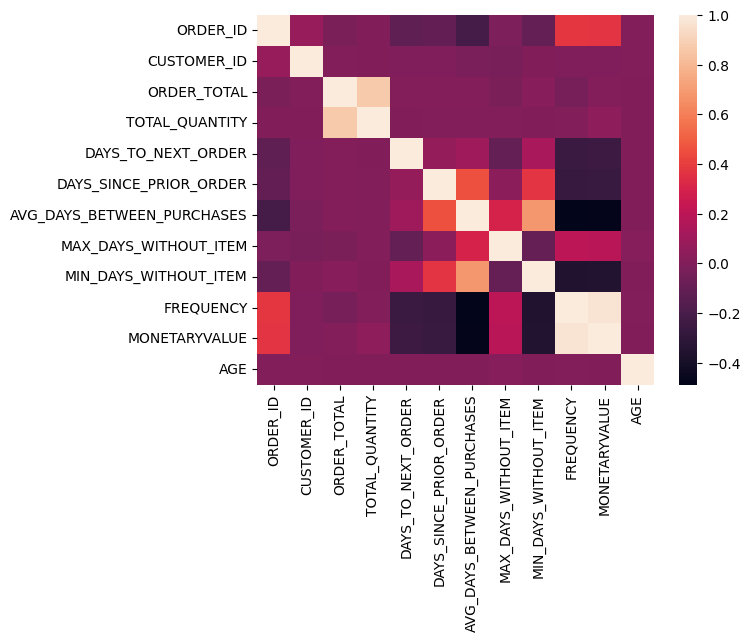

In [37]:
temp_df=new_orders_df.to_pandas()
sns.heatmap(temp_df.corr())
plt.show()

#Recency
recency=new_orders_df.group_by('CUSTOMER_ID').max('ORDER_TS').to_pandas()
recency['RECENCY']=(dt.datetime(2022,10,31)-pd.to_datetime(recency['MAX(ORDER_TS)'])).dt.days

#Frequency
frequency=new_orders_df.group_by('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency')).to_pandas()

#Monetary
monetary=new_orders_df.group_by('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary')).to_pandas()

RFM_table=recency.merge(right=frequency, how="inner",on='CUSTOMER_ID')
RFM_table=RFM_table.merge(right=monetary,how='inner',on='CUSTOMER_ID')
RFM_table.drop(labels='MAX(ORDER_TS)',inplace=True,errors='ignore')

quantiles_1 = RFM_table[['RECENCY','FREQUENCY','MONETARY']].quantile(q=[0.2,0.4,0.6,0.8])

# Converting quantiles to a dictionary, easier to use.
quantiles = quantiles_1.to_dict()
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x<=d[p][0.8]:
        return 2 
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x<=d[p][0.8]:
        return 4 
    else:
        return 5
RFM_Segment['R_Quartile'] = RFM_Segment['RECENCY'].apply(R_Class, args=('RECENCY',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['FREQUENCY'].apply(FM_Class, args=('FREQUENCY',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['MONETARY'].apply(FM_Class, args=('MONETARY',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [38]:
temp_df_2=temp_df.drop(['ORDER_TS','ORDER_ID'],axis=1)

In [39]:
temp_df_3=temp_df_3.drop(['CITY','TRUCK_BRAND_NAME','MENU_TYPE','TIME_OF_DAY'],axis=1)

NameError: name 'temp_df_3' is not defined

In [ ]:
temp_df_3['DAYS_TO_NEXT_ORDER'].describe()

count    687727.000000
mean        139.545385
std         131.005169
min           1.000000
25%          41.000000
50%         100.000000
75%         199.000000
max         997.000000
Name: DAYS_TO_NEXT_ORDER, dtype: float64

In [ ]:
temp_df_3['NextPurchaseDayRange'] = 3
temp_df_3.loc[temp_df_3['DAYS_TO_NEXT_ORDER']>41,'NextPurchaseDayRange'] = 2
temp_df_3.loc[temp_df_3['DAYS_TO_NEXT_ORDER']>100,'NextPurchaseDayRange'] = 1
temp_df_3.loc[temp_df_3['DAYS_TO_NEXT_ORDER']>199,'NextPurchaseDayRange'] = 0


In [ ]:
# Define Model Inputs (X) and Output (y)
X = temp_df_3.drop(['DAYS_TO_NEXT_ORDER','NextPurchaseDayRange'], axis =1)
y = temp_df_3["NextPurchaseDayRange"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

#Performing one hot encoding
ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True, 
    variables=['Segment']
)  

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)


In [ ]:
#Split into Training 60, Testing 20, Validate 10, and Holdout 10

In [ ]:
X_train[X_train['CUSTOMER_ID']==115199]

,CUSTOMER_ID,ORDER_TOTAL,TOTAL_QUANTITY,DAYS_SINCE_PRIOR_ORDER,AVG_DAYS_BETWEEN_PURCHASES,MAX_DAYS_WITHOUT_ITEM,MIN_DAYS_WITHOUT_ITEM,FREQUENCY,MONETARYVALUE,AGE
583117,115199,104.00,6,18,20,88,2,36,1587.50,35
583115,115199,34.50,2,32,21,88,2,34,1469.50,35
583125,115199,71.00,5,16,20,88,2,44,1931.75,35
583133,115199,186.00,11,12,19,88,1,52,2375.25,35
583112,115199,71.00,8,40,22,88,2,31,1316.50,35
583093,115199,11.00,1,6,29,88,4,12,535.75,35
583107,115199,37.00,3,36,22,88,2,26,1034.50,35
583104,115199,42.00,8,3,20,88,2,23,932.50,35
583111,115199,33.00,3,21,21,88,2,30,1245.50,35
583124,115199,8.00,1,11,20,88,2,43,1860.75,35


# Model Training

In [ ]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
#Build XGBoost Model
xgb = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [ ]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateClassificationModelPerformance(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test))

In [ ]:
#Evaluate XGBoost Model
evaluateClassificationModelPerformance(xgb)

Train Accuracy: 0.911842700267414 
Test Accuracy: 0.9119764483156898


In [ ]:
#Check top 10 features based on feature importance
ft_weights_xgb_clf = pd.DataFrame(xgb.feature_importances_, columns=['is_promoted'], index=X_train.columns)
ft_weights_xgb_clf.sort_values('is_promoted', ascending=False, inplace=True)
ft_weights_xgb_clf.tail(100)

,is_promoted
FREQUENCY,0.812780
AVG_DAYS_BETWEEN_PURCHASES,0.070948
MAX_DAYS_WITHOUT_ITEM,0.036107
DAYS_SINCE_PRIOR_ORDER,0.014956
CUSTOMER_ID,0.013351
AGE,0.012764
ORDER_TOTAL,0.010782
MIN_DAYS_WITHOUT_ITEM,0.010632
MONETARYVALUE,0.009954
TOTAL_QUANTITY,0.007726


# Model Deployment

# Model Utilization

# Reset
We will run the following cell to remove the objects from Snowflake that we created in this notebook. Dropping our stage will remove the model file. We will also close our Snowflake session.<br>

In [44]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""

'# Drop training table\nsession.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()\n\n# Drop testing table\nsession.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()\n\n# Drop training stored procedure\nsession.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()\n\n# Drop inference user-defined function\nsession.sql(\n    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"\n).collect()\n\n# Drop stage\nsession.sql("DROP STAGE IF EXISTS model_stage").collect()\n\n# Scale down compute\nsession.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()\n\n# Close the session\nsession.close()'